# Контекст

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что пользователь больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

## План выполнения работ
### [Шаг 1. Загрузите данные](#step1)
### [Шаг 2. Проведите исследовательский анализ данных (EDA)](#step2)
### [Шаг 3. Постройте модель прогнозирования оттока пользователей](#step3)
### [Шаг 4. Сделайте кластеризацию пользователей](#step4)
### [Шаг 5. Сформулируйте выводы и сделайте базовые рекомендации по работе с клиентами](#step5)

## <a id="step1"> Шаг 1. Загрузите данные</a>

#### Импортируем библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', 500)

####  Рассмотрим полученные данные gym_churn.csv

In [2]:
#gym_churn = pd.read_csv('/Users/vladimrogulo/PycharmProjects/Praktikum11/gym_churn.csv')
gym_churn = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
print('\nРазмер датафрейма: ', gym_churn.shape)
print('\nРассмотрим общую информацию')
gym_churn.info()
print('\nВыведем DataFrame на экран')
display(gym_churn.head())


Размер датафрейма:  (4000, 14)

Рассмотрим общую информацию
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


##### Описание  данных 

`Churn` — факт оттока в текущем месяце;

Данные пользователя за предыдущий до проверки факта оттока месяц:
- `gender` — пол
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- `Phone` — наличие контактного телефона
- `Age` — возраст
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах)


Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах)
- `Group_visits` — факт посещения групповых занятий
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

#### Вывод
Размер датафрейма  - 4000х14, это значит мы имеем 4000 наблюдений, 13 признаков и целевую переменную.

Видим, что пропусков нет и все признаки численные. 

## <a id="step2"> Шаг 2. Проведите исследовательский анализ данных (EDA)</a>

In [4]:
print('\nРассмотрим описательную статистику нашего DataFrame')
gym_churn.describe()


Рассмотрим описательную статистику нашего DataFrame


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [5]:
display(gym_churn.groupby('Churn').mean())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


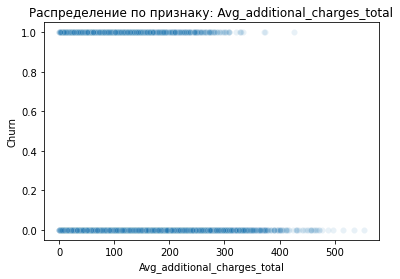

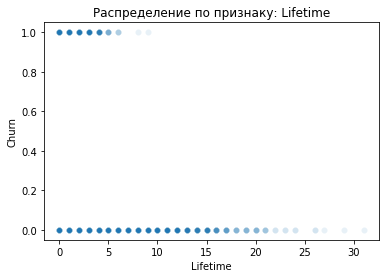

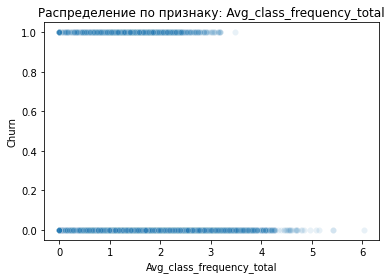

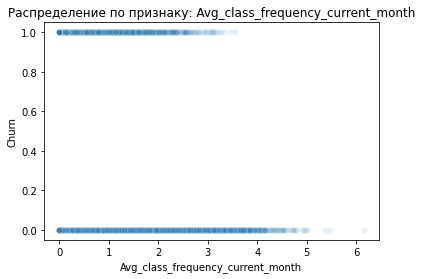

In [6]:
#построим попарные диаграммы рассеяния признак-целевая переменная для каждого признака
columns_scatter = ['Avg_additional_charges_total','Lifetime',
                  'Avg_class_frequency_total','Avg_class_frequency_current_month']
columns_hist = ['Age','gender','Month_to_end_contract','Near_Location','Partner','Promo_friends', 'Phone',
                'Contract_period','Group_visits']
for col in columns_scatter:
    g = sns.scatterplot(gym_churn[col], gym_churn['Churn'], alpha = 0.1)
    title = 'Распределение по признаку: ' + col
    g.set_title(title)
    plt.show()

Гистограмма Age


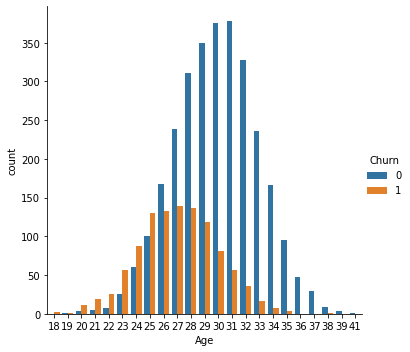

Гистограмма gender


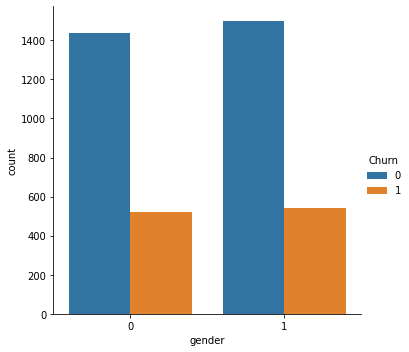

Гистограмма Month_to_end_contract


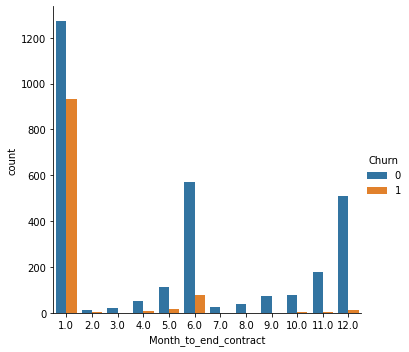

Гистограмма Near_Location


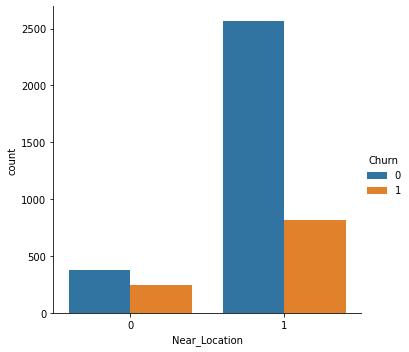

Гистограмма Partner


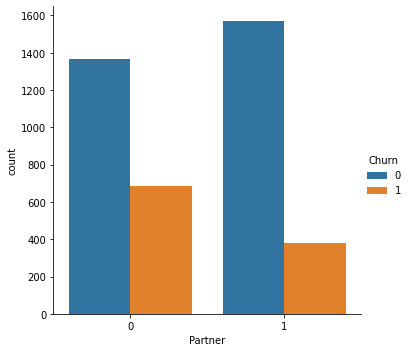

Гистограмма Promo_friends


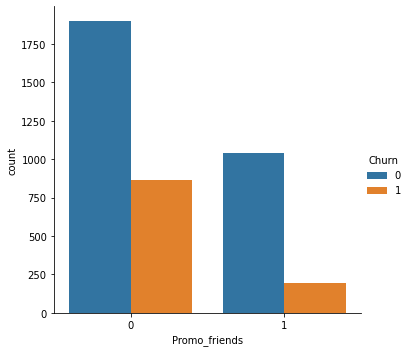

Гистограмма Phone


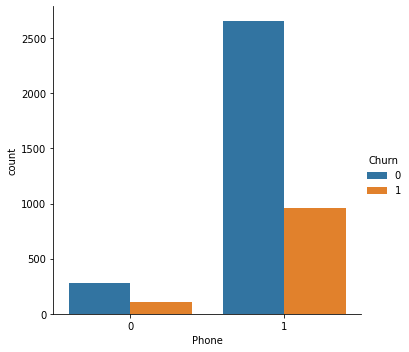

Гистограмма Contract_period


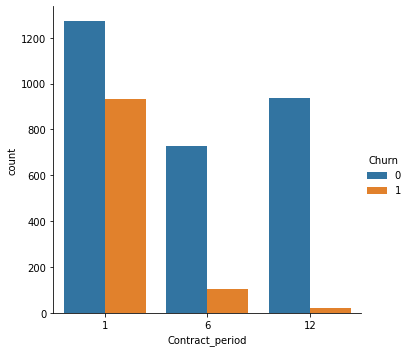

Гистограмма Group_visits


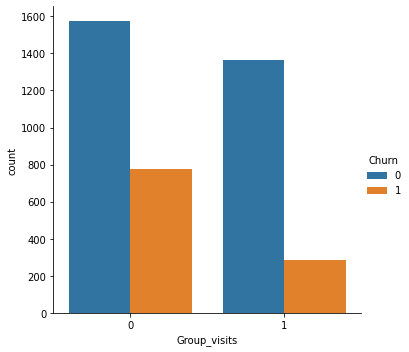

In [7]:
for col in columns_hist:
    print('Гистограмма '+ col)
    sns.catplot(x=col, kind="count", hue='Churn', data = gym_churn)
    plt.show()

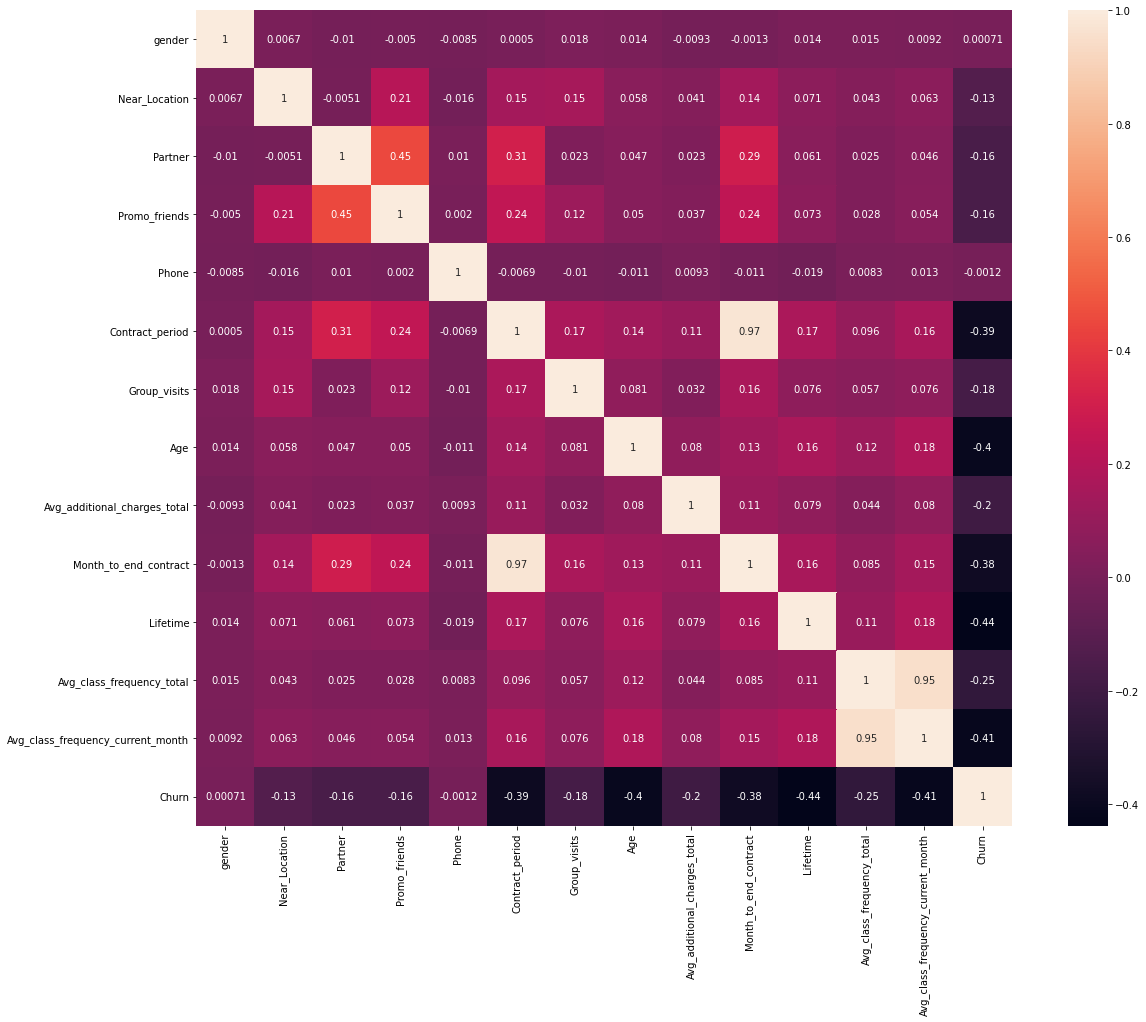

In [8]:
#вычислим матрицу корреляций
cm = gym_churn.corr() 
plt.subplots(figsize=(20,15))
#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot = True, square=True)#ваш код здесь
 


#### Вывод
Обратим внимание, что большинство пользователей осталяет номер телефона(среднее значение у нас 0,903).

Также можем заметить, что пользователи, которые имеют месячный абонемент, бросают тренировки чаще, чем люди с более длительными абонементами. Наши данные говорят, что гендер практически никак не влияет на отток. 

Чем дольше люди ходят в фитнес-клуб, тем меньше среди данных клиентов отток.Также можем заменить, что средний возраст людей, которые бросают ходить заниматься(27 лет) меньше, чем у людей, которые продолжают заниматься из месяца в месяц (30 лет). Люди, которые ходят на групповые занятия реже прекращают заниматься. Люди, у которых остался месяц до окончания абонемента склонны чаще бросать тренировки. 

На основании матрицы корреляций можно сделать вывод, что значения `Avg_class_frequency_current_month` и `Avg_class_frequency_total`, а также `Month_to_end_contract` и `Contract_period` сильно коррелируют. 

А теперь тезисно: 
- Люди, которые меньше денег тратят на дополнительные услуги фитнес центра более склонны к оттоку.
- Люди, бросают фитнес клуб в первые 5 месяцев занятий, далее их можно считать надежными постоянниками.
- Стоит держаться за клиентов, которые посещают фитнес более 4 раз в неделю, они не могут жить без спорта.
- Наибольший отток у пользователей возрастом 25-29 лет.
- Пол никак не сказывается на отток. Наши данные хорошо сбалансированны по гендеру.
- Большинство клиентов бросают занятия в первый месяц занятий.
- Большинство пользователей оставляют свой номер телефона.
- Высокий отток у людей, оформивших абонемент на месяц
- Групповые занятия также хорошо влияют на удержание клиентов.

## <a id="step3"> Шаг 3. Постройте модель прогнозирования оттока пользователей</a>

#### Разбейте данные на обучающую и валидационную выборку функцией train_test_split()

In [9]:
X = gym_churn.drop('Churn', axis = 1)#ваш код здесь
y = gym_churn['Churn']

In [10]:
#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
#  создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

#### Обучите модель на train-выборке двумя способами:

In [12]:
# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:,1]
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('\tRecall: {:.2f}'.format(recall_score(y_test, predictions)))
    print('\tF1: {:.2f}'.format(f1_score(y_test, predictions)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities)))

In [13]:
# Задаем список моделей для обучения
models = [LogisticRegression(), RandomForestClassifier()]

In [14]:
for i in models:
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

LogisticRegression()
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
	F1: 0.84
	ROC_AUC: 0.97
RandomForestClassifier()
	Accuracy: 0.91
	Precision: 0.84
	Recall: 0.80
	F1: 0.82
	ROC_AUC: 0.97


#### Вывод
Из метрик видим, что доля правильных ответов у модели `LogisticRegression()` выше, как и точность и полнота. Баланс (F1) у этой модели выше. Оценка качества (AUC-ROC) у двух моделей одинаковая и равна 0.97.
В данном челлендже выигрывает модель `LogisticRegression`. 

PS. При тестировании на не стандартизированных данных `LogisticRegression` показала себя хуже RandomForestClassifier

## <a id="step4"> Шаг 4. Сделайте кластеризацию пользователей</a>

In [15]:
# Стандартизация данных
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [16]:
linked = linkage(X_sc, method = 'ward') 

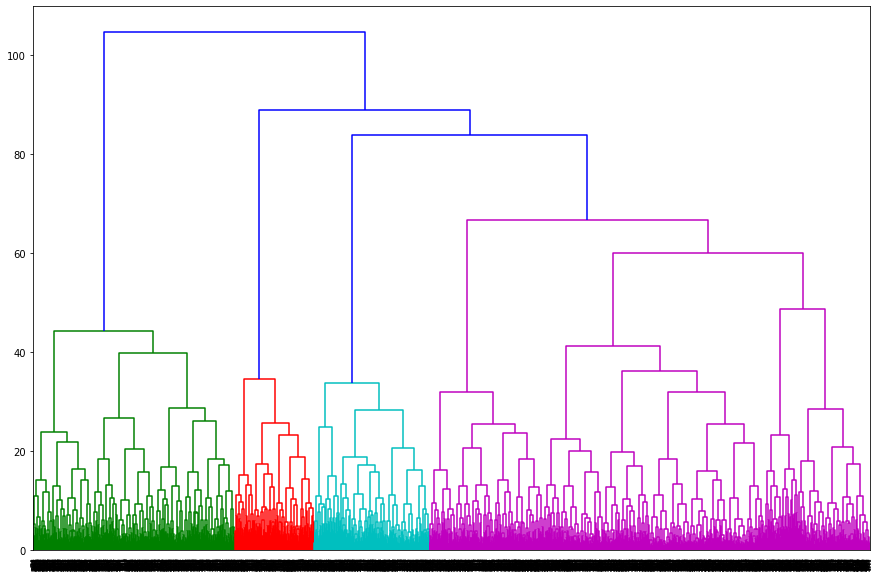

In [17]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

По дендрограмме можно визуально оценить,что кластеров будет 5 или 6. 

In [18]:
# задаём модель k_means с числом кластеров 3
km = KMeans(n_clusters = 5)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_sc)

In [19]:
# сохраняем метки кластера в поле нашего датасета
gym_churn['cluster_km'] = labels

In [20]:
# выводим статистику по средним значениям наших признаков по кластеру
display(gym_churn.groupby('cluster_km').mean())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.499423,0.936563,0.740484,0.479815,1.0,11.833910,0.546713,29.886967,163.433556,10.791234,4.710496,1.999869,1.992114,0.021915
1,0.482950,0.724029,0.296590,0.013481,1.0,1.925456,0.275178,28.128469,129.924060,1.831879,2.212530,1.252643,1.001345,0.560666
2,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839
3,0.496795,0.948718,0.818910,0.998397,1.0,3.038462,0.439103,29.088141,140.822919,2.844551,3.722756,1.720559,1.613392,0.258013
4,0.564965,0.848028,0.276102,0.069606,1.0,2.664733,0.451276,30.040603,160.911740,2.466357,4.850348,2.799601,2.791346,0.082367


#### Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?

In [21]:
columns_scatter.append('cluster_km')

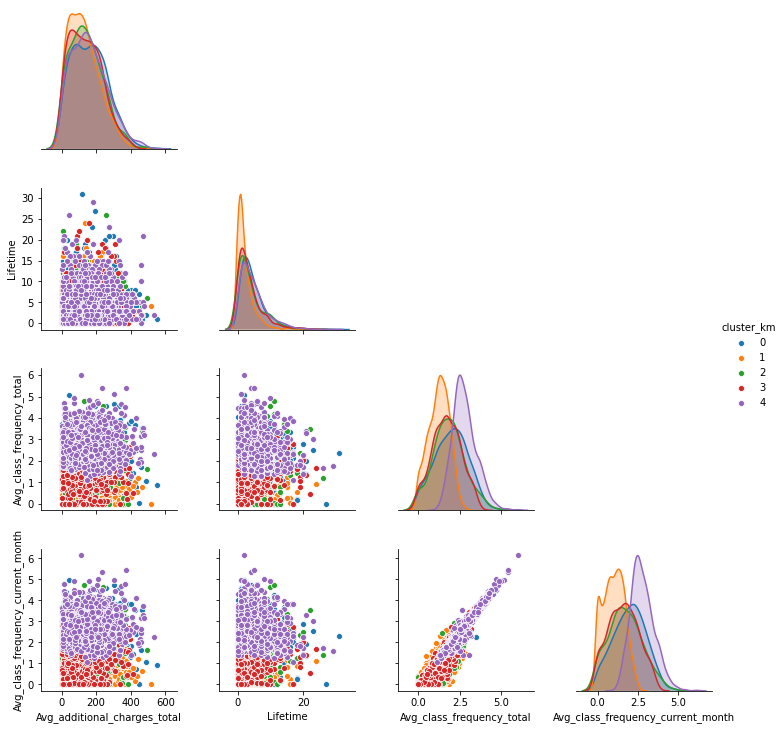

In [22]:
g = sns.pairplot(gym_churn[columns_scatter], hue="cluster_km", diag_kind="kde", height=2.5,corner=True)

In [23]:
gym_churn.columns

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
       'Churn', 'cluster_km'],
      dtype='object')

In [24]:
columns_hist_1 = ['Promo_friends', 'Contract_period',
                  'Lifetime','Avg_class_frequency_current_month','cluster_km']

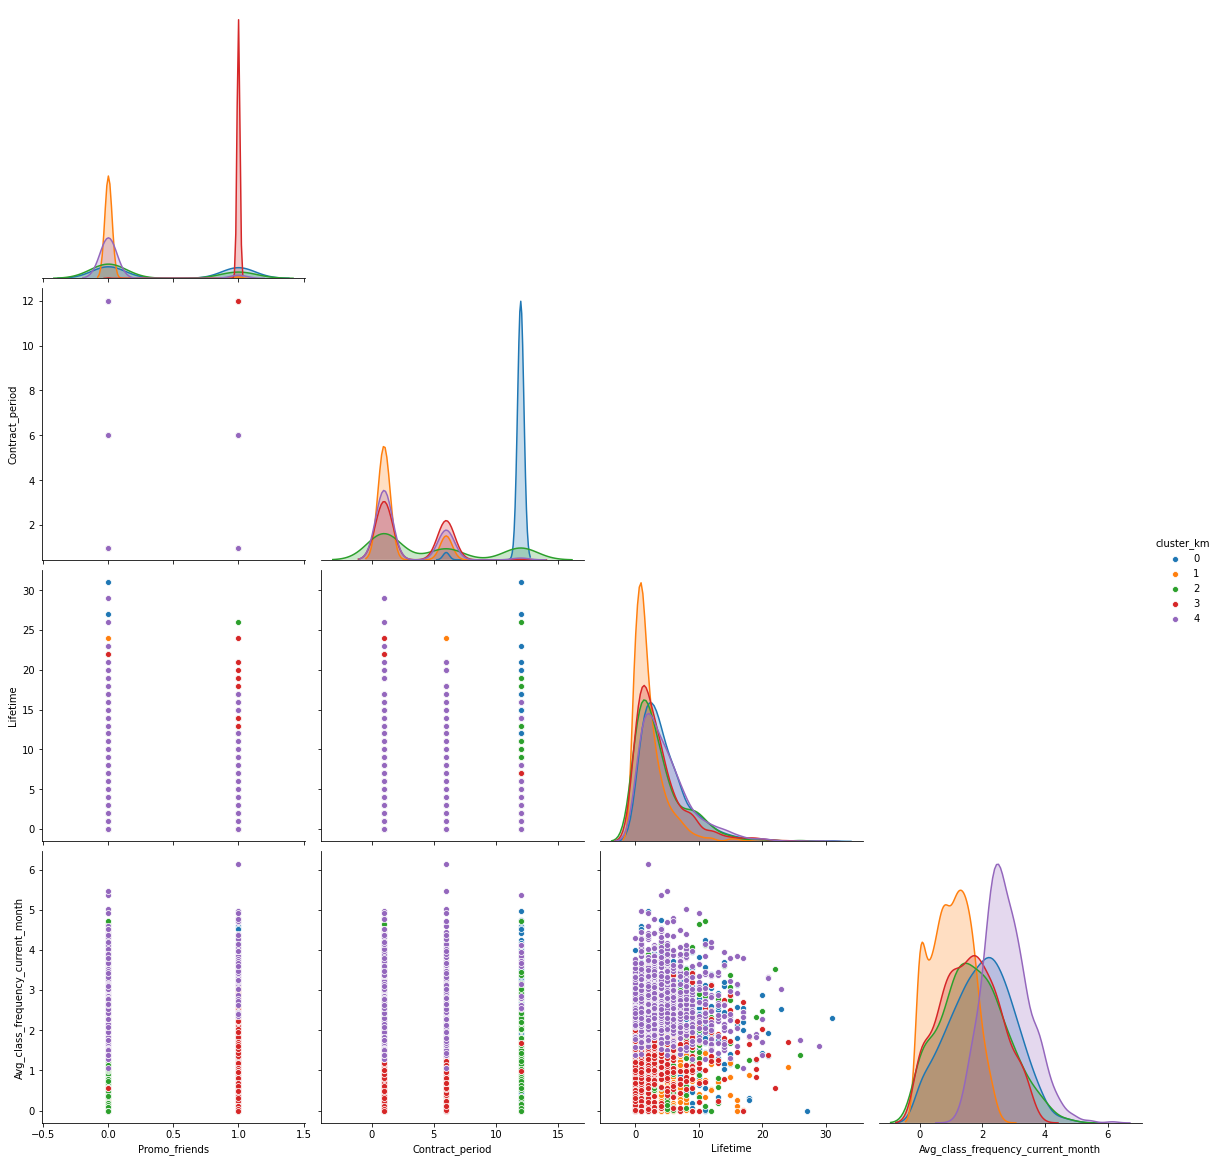

In [25]:
g = sns.pairplot(gym_churn[columns_hist_1], hue="cluster_km", kind = "scatter",diag_kind="auto", height=4, corner=True)

In [26]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.13


#### Вывод
Значение метрики силуэта оказалось не очень высоким. Из графиков видно, что нет чётко отделяемых групп на попарных графиках. Также прослеживается корреляция между признаками `Avg_class_frequency_total` и `Avg_class_frequency_current_month`. 

#### Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [27]:
# Сгруппируем таблицы и найдем количетство вхождений в каждый кластер, а также общее значение событий в кластере
gym_churn_fraction = gym_churn.groupby(['cluster_km','Churn']).agg({'gender':'count'}).reset_index()
gym_churn_fraction.columns = ['cluster_km','Churn','fraction']
gym_churn_group_all = gym_churn.groupby('cluster_km').agg({'gender':'count'}).reset_index()
gym_churn_group_all.columns = ['cluster_km','all_count']

In [28]:
# объединим таблицы
gym_churn_group = gym_churn_fraction.merge(gym_churn_group_all, how='left', on='cluster_km')

In [29]:
gym_churn_group['rate'] = gym_churn_group['fraction'] / gym_churn_group['all_count']

In [30]:
display(gym_churn_group[['cluster_km','Churn','rate']])

,cluster_km,Churn,rate
0,0,0,0.978085
1,0,1,0.021915
2,1,0,0.439334
3,1,1,0.560666
4,2,0,0.733161
5,2,1,0.266839
6,3,0,0.741987
7,3,1,0.258013
8,4,0,0.917633
9,4,1,0.082367


In [31]:
display(gym_churn_group)

,cluster_km,Churn,fraction,all_count,rate
0,0,0,848,867,0.978085
1,0,1,19,867,0.021915
2,1,0,554,1261,0.439334
3,1,1,707,1261,0.560666
4,2,0,283,386,0.733161
5,2,1,103,386,0.266839
6,3,0,463,624,0.741987
7,3,1,161,624,0.258013
8,4,0,791,862,0.917633
9,4,1,71,862,0.082367


#### Вывод
Сеть фитнес-центров «Культурист-датасаентист» должна обратить пристальное внимание на пользователей, которые входят в кластер 2(6%), 4(2%) и 3(24%). Кластеры 0(52%) и 1(45%) склонны к оттоку, на них следуют обращать меньше внимания. Из графиков и средних значений видно, что промокоды делают свое дело и данный признак свойственен кластеру 3 и в меньшей степери кластеру 4.

## <a id="step5"> Шаг 5. Сформулируйте выводы и сделайте базовые рекомендации по работе с клиентами</a>

В нашей работе мы имели дело с  4000 наблюдениями, 13 признаками и целевой переменной. Данные чисты, отсутвовали пропуска.

На основе исследовательского анализа данных (EDA), мы получили ряд тезисов: 
- Люди, которые меньше денег тратят на дополнительные услуги фитнес центра более склонны к оттоку.
- Люди, бросают фитнес клуб в первые 5 месяцев занятий, далее их можно считать надежными постоянниками.
- Стоит держаться за клиентов, которые посещают фитнес более 4 раз в неделю, они не могут жить без спорта.
- Наибольший отток у пользователей возрастом 25-29 лет.
- Пол никак не сказывается на отток. Наши данные хорошо сбалансированны по гендеру.
- Большинство клиентов бросают занятия в первый месяц занятий.
- Большинство пользователей оставляют свой номер телефона.
- Высокий отток у людей, оформивших абонемент на месяц
- Групповые занятия также хорошо влияют на удержание клиентов.

Построив модель прогнозирования оттока мы вяснили, что модель Логистической регрессии на стандартизированных данных показывает результат немного лучше, чем Случайный лес. Тут мы отдаем предпочтение `LogisticRegression`

Далее мы приступили к кластеризации пользователей. Построив матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисовав дендрограмму, было принтято 5 кластеров. На основании этих кластеров были получены средние значения для всех признаков, а также доля оттока клиентов по кажому кластеру. Кластеры 0 и 1 оказались более склонны к оттоку. 

Перейдем к рекомендациям по работе с клиентами. 

*Увеличить продажи абонементов на 3 и более месяцев*

- Так как большинство клиентов бросают занятия в первый месяц, а также высокий отток клиентов, которые оформили абонемент на месяц, то стоит сконцентрироваться на продаже абонементов на 3 и более месяцев. Это стимулирует клиентов возвращаться к тренировкам. 


*Поработать с привлечение аудитории*

- Стоит настроить таргетинг таким образом, чтобы возрастная группа была от 29 лет. С каждым годом жизни клиент все больше задумывается о здоровье и физической форме, а соответственно регулярно посещает фитнес (настройка таргетинга)

*Групповые занятия*

- Групповые занятия - это все таки присутствие людей в кругу единомышленников. Хороше бы поработать на программой групповых занятий, чтобы люди как можно чаще приходили в зал. А как мы знаем, групповые занятия и количество занятий в неделю(>3) хорошо сказываются на удержании клиентов

*Увеличение продаж дополнительных услуг*

- Сконцентрировать свое внимание на продаже доп. услуг. Это снижает отток клиентов.

*Присмотреться к кластеризации клинетов*

- Хоть мы и получили Значение небольшое значение  метрики силуэта, но все такие стоит прибегнуть к кластеризации. Ведь клиенты кластеров 2, 3, 4 имеют низкую долю оттока.